In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import expectexception

In [3]:
sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: images/sq-circ.svg -->
<!-- requirement: images/oct-circ.svg -->
<!-- requirement: images/newtons.svg -->

# Iterative Algorithms


While it is always nice to be able to write down a single expression to do a calculation, very few of the things we wish to calculate can be calculated exactly.  Instead, we must use approximation schemes. Most work in an iterative manner: Starting with a simple approximation of the order, a calculation is made to improve the approximation.  This calculation can then be iterated to continually improve the approximation.

This is what TensorFlow is really built for.  All of the work of setting up a computation graph first is not really worth it if the calculation needs to run only once.  But when the same calculation is repeated over and over, that extra initial work pays off again and again.

Before we look at how to implement an iterative algorithm in TensorFlow, let's remind ourselves of one of the oldest such algorithms out there:


## Archimedes' algorithm in Python


By definition a circle with radius $1$ has a circumference of $2\pi$.  Archimedes realized that you could get an estimate for the circumference by taking the perimeter of polygon (which he could calculate) that either circumscribed the unit circle or was inscribed within it.  Here are circumscribed and inscribed squares:

![squares](images/sq-circ.svg)

We'll let $P_n$ be the perimeter of the circumscribed $n$-gon and $p_n$ be the perimeter of the inscribed $n$-gon.  With just a little bit of geometry, you can work out that

$$ P_4 = 8 $$
$$ p_4 = 4\sqrt2 \approx 5.66 $$

The actual value of $2\pi \approx 6.28$ is between them; in fact $(P_4 + p_4)/2 \approx 6.82$ is an even better approximation.

As we increase the number of sides, the polygons get closer to the circles, and the inscribing and circumscribing polygons will continue to bracket the circumference of the circle.  You can easily see this visually with octagons:

![octagons](images/oct-circ.svg)

Working out the circumference of each $n$-gon on its own would be quite tedious.  (Archimedes made it up to $n=96$!)  Luckily for us, there is a relatively simple recursive formula that gives us the perimeters of the $2n$-gons in terms of the perimeters of the $n$-gons:

$$ P_{2n} = \frac{2 p_n P_n}{p_n + P_n} $$
$$ p_{2n} = \sqrt{p_n P_{2n}} $$

Thus, starting with $n = 4$, we can easily calculate $n = 8$, $16$, $32$, ....

We'll illustrate this first with basic Python.  We start with the perimeters for the squares:

In [4]:
p_insc = 4 * 2**0.5
p_circ = 8

In [7]:
pow2 = 1

Then we'll double $n$ ten times, reporting the average of the two perimeters each time.  Note that $P_{2n}$ depends on $P_n$ and $p_n$, while $p_{2n}$ depends on $p_n$ and $P_{2n}$.  Therefore, we can update the circumscribed circumference before the the inscribed circumference.

In [8]:
for i in range(10):
    p_circ = 2 * p_insc * p_circ / (p_insc + p_circ)
    p_insc = np.sqrt(p_insc * p_circ)
    
    print((p_circ + p_insc) / 2)

6.283185384184518
6.283185326430818
6.283185311992394
6.283185308382787
6.283185307480387
6.2831853072547865
6.283185307198385
6.283185307184285
6.283185307180759
6.283185307179878


By the end, we are dealing with a $4096$-gon.  Look how close our estimate is.

In [9]:
(p_circ + p_insc) / 2 - 2*np.pi

2.922107000813412e-13

## Archimedes' algorithm in TensorFlow


These calculations are simple enough to do in TensorFlow.  They involve only simple mathematical operations, so setting up the graph should be no problem.  There is one important step that we haven't considered: updating the values each step.

We could take the approach of using placeholders, and updating them with the new value each time.

In [10]:
reset_tf()

p_insc = tf.placeholder(np.float64, name="Inscribed_Permimeter")
p_circ = tf.placeholder(np.float64, name="Circumscribed_Perimeter")

Then we also define the updated values:

In [11]:
update_circ = 2 * p_circ * p_insc / (p_circ + p_insc)
update_insc = tf.sqrt(p_insc * p_circ)
estimate_2pi = (p_circ + p_insc) / 2

Now we can run these iteratively, storing the updated values, so we can feed in the updated values at the next step.

In [12]:
p_insc_val = 4 * np.sqrt(2)
p_circ_val = 8
for i in range(10):
    p_circ_val = sess.run(update_circ,
                          feed_dict={p_circ: p_circ_val,
                                     p_insc: p_insc_val})
    p_insc_val = sess.run(update_insc,
                          feed_dict={p_circ: p_circ_val,
                                     p_insc: p_insc_val})
    print(sess.run(estimate_2pi, feed_dict={p_circ: p_circ_val,
                                            p_insc: p_insc_val}))

6.37517595790548
6.304043030332581
6.288273397975196
6.284449542200658
6.283500880875231
6.283264170313269
6.283205021070274
6.2831902355339695
6.2831865392607895
6.283185615199425


This works, but it is obviously inconvenient.  It gives us two objects for each value, and we need to make sure we're always feeding in the correct value to the correct placeholder.  This is clearly inviting errors.

Fortunately, there's a better way.


## Variables


In addition to constants and placeholders, TensorFlow provides **variables**.  These tensors hold values much like others, but these values can be updated during a computation.  We will use variables again and again to hold parameters of models that need to be updated during training.

Variables are created with an initial value.  Like other tensors, they can be given a name and a `dtype`.

In [13]:
var = tf.Variable(3, name="my_var", dtype=np.int32)

However, if you try to run a variable, you'll run into a problem:

In [14]:
%%expect_exception tf.errors.FailedPreconditionError

sess.run(var)

---------------------------------------------------------------------------
FailedPreconditionError                   Traceback (most recent call last)
/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _do_call(self, fn, *args)
   1277     try:
-> 1278       return fn(*args)
   1279     except errors.OpError as e:

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _run_fn(feed_dict, fetch_list, target_list, options, run_metadata)
   1262       return self._call_tf_sessionrun(
-> 1263           options, feed_dict, fetch_list, target_list, run_metadata)
   1264 

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _call_tf_sessionrun(self, options, feed_dict, fetch_list, target_list, run_metadata)
   1349         self._session, options, feed_dict, fetch_list, target_list,
-> 1350         run_metadata)
   1351 

FailedPreconditionError: Attempting to use uninitialized value m

Variables must be initialized before they are run.  The simplest way to do that is with `global_variables_initializer()`.  This TensorFlow operation will initialize all variables.

In [15]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(var)

3

There are many other ways to [initialize variables](https://www.tensorflow.org/programmers_guide/variables#initialization).  Values can be stored on disk and restored later.  You can also initialize only the subset of variables that concern you.  We will use the global `initializer` so much that we'll make a simple function to run it in our global session:

In [16]:
def reset_vars():
    sess.run(tf.global_variables_initializer())

Variables don't have to be initialized with a known value. In some cases, we'll want to initialize values randomly.  Here we create a random tensor of shape `[2, 2]` with values drawn from a normal distribution with $\sigma = 1$ and $\mu=2$.

In [17]:
rand_var = tf.Variable(tf.random_normal([2, 2], stddev=1, mean=2))
reset_vars()
print(sess.run(rand_var))

[[2.0181897  0.9832425 ]
 [0.72835124 0.7756084 ]]


Variables can be updated with the *assign* operation.

In [18]:
change_var = var.assign(5)

Note that this is an operation.  Nothing changes until the assignment is actually run.

In [19]:
print(sess.run(var))
print(sess.run(change_var))
print(sess.run(var))

3
5
5


More typically, the value of a variable will be updated based on current values.

In [20]:
double_var = var.assign(var * 2)
print(sess.run(double_var))
print(sess.run(double_var))

10
20


The value of each variable exists only within a given session.  If you start with another session, variables will have a separate value in that one.

In [21]:
sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
print("New session:", sess2.run(var))
print("Old session:", sess.run(var))

New session: 3
Old session: 20


In [22]:
pow2 = tf.Variable(1, dtype=np.int32)

In [23]:
updatepow = pow2*2

In [ ]:
pow2 =

## Archimedes' algorithm done idiomatically


Now we can re-run our estimation for $2\pi$ using TensorFlow variables.  We'll start them off with the values for $n = 4$.

In [ ]:
p_insc = tf.Variable(4 * np.sqrt(2), name="Inscribed_Perimeter", dtype=np.float64)
p_circ = tf.Variable(8.0, name="Circumscribed_Perimeter", dtype=np.float64)

The update operations will now assign the value for $2n$ back to the variable.  Our estimate is unchanged.

In [ ]:
update_circ = p_circ.assign(2 * p_circ * p_insc / (p_circ + p_insc))
update_insc = p_insc.assign(tf.sqrt(p_insc * p_circ))
estimate_2pi = (p_circ + p_insc) / 2

Finally, our iterative step just runs the two updates and then prints the current estimate.  Notice how much cleaner this is than the previous approach.

In [ ]:
reset_vars()

for i in range(10):
    sess.run(update_circ)
    sess.run(update_insc)
    print(sess.run(estimate_2pi))

A collection of tensors can be passed to the `run()` method.  What happens if we tell TensorFlow to run all three steps at once?

In [ ]:
reset_vars()

for i in range(10):
    print(sess.run([update_circ, update_insc, estimate_2pi]))

As you probably notice, we no longer get the right answer!  When used in this way, TensorFlow gives no guarantees about the order in which operations get run.  Because our algorithm requires the circumscribed perimeter to be updated before the inscribed, it is broken by this lack of guarantee.

## Exercise: Fibonacci numbers


Build an iterative TensorFlow graph that calculates the $n^{th}$ Fibonacci number $F_n$.  Recall that $F_n = F_{n-1} + F_{n-2}$, with $F_1 = F_2 = 1$.  Use this to find $F_{80}$.

In [24]:
fibs = tf.Variable([1,1])
update_fibs = fibs.assign([fibs[1],fibs[0] + fibs[1]])
reset_vars()
for i in range(10):
    sess.run(update_fibs)
    print(sess.run(fibs[0]))

1
2
3
5
8
13
21
34
55
89


## Newton's Method of Root Finding


Newton's method is a technique for finding the roots of a function.  That is, given a function $f(x)$, it will find a root $x^*$ such that $f(x^*) = 0$.

The algorithm works iteratively.  Given a starting position $x_0$, it approximates the function nearby as a straight line with slope $f'(x_0)$:

$$ f(x) \approx f(x_0) + f'(x_0) (x - x_0) $$

![newton's method](images/newtons.svg)

We use this approximation to get a better estimate of the root:

$$ x_{1} = x_0 - \frac{f(x_0)}{f'(x_0)} $$

This process is then iterated.  At each step, we use the existing estimate of the root to make the next estimate.

$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

As a simple example, let's take $f(x) = x^2 - 2$, which has roots $x = \pm\sqrt2$.  We'll keep track of our current estimate of the root in a variable:

In [25]:
reset_tf()

x = tf.Variable(0.05, name="root", dtype=np.float64)

We have purposefully started the estimate far from the root so that we can observe the approach.

Defining $f$ is easy enough.  Similarly, if we remember our calculus, we know that $f'(x) = 2x$.

In [26]:
f = x * x - 2
fp = 2 * x

Note that we don't make `f` or `fp` into functions; they are tensors just like `x`.  Because TensorFlow is lazy in its evaluation, their values are only calculated when needed.  When that calculation is done, the current value of `x` is used, so they will always be up to date with `x`.

In [27]:
reset_vars()

print(sess.run([x, f]))
sess.run(x.assign(2))
print(sess.run([x, f]))

[0.05, -1.9975]
[2.0, 2.0]


The iterative step updates the value of `x` from the current position, function value, and function derivative.

In [28]:
iterate = x.assign(x - f / fp)

Now we can run this for a number of steps.

In [29]:
reset_vars()

for i in range(10):
    print(sess.run(iterate))

20.025
10.062437578027465
5.130598287494659
2.7602081863120933
1.7423956061509767
1.4451202788151059
1.414544062586548
1.414213600982847
1.4142135623730956
1.4142135623730951


Let's see how well we did:

In [30]:
sess.run(x) - np.sqrt(2)

0.0

We've managed to find the correct value to within floating point accuracy, in only 10 steps.  Not bad!

We were able to write this easily because the function was easy to differentiate.  What if we're faced with some hideous function?

Luckily for us, TensorFlow can take derivatives for us!  Recall that when we define something like `f = x * x + 2`, we are not calculating a value for `f`.  Instead, we are recording the operations necessary to calculate `f`.  As long as each operation knows how derivatives should be taken, it is easy enough to use the chain rule to calculate the full derivative.

This functionality is provided by the `gradients()` function.  The gradient is a generalization of the derivative to handle tensors.  If $\mathbf{x} = \left(x_1, x_2, ...\right)$ is a tensor,

$$ \nabla f = \left( \frac{\partial f}{\partial x_1},
\frac{\partial f}{\partial x_2}, ... \right) $$

This function takes two arguments: the tensor to be differentiated and the tensor to do the differentiation.  In this case, we want the derivative of `f` with respect to `x`.

In [31]:
fp_auto = tf.gradients(f, x)[0]  # Gives an array of length 1 in this case

We can see that it gives the same values as the derivative we calculated by hand.

In [32]:
sess.run(x.assign(2))
sess.run([fp, fp_auto])

[4.0, 4.0]

We can use it in our Newton's method calculation just like we did with the previous derivative.

In [33]:
iterate_auto = x.assign(x - f / fp_auto)

reset_vars()

for i in range(10):
    print(sess.run(iterate_auto))

20.025
10.062437578027465
5.130598287494659
2.7602081863120933
1.7423956061509767
1.4451202788151059
1.414544062586548
1.414213600982847
1.4142135623730956
1.4142135623730951


## Exercise: Minimizing functions


We can use a similar algorithm to find minima of functions.  At the minimum (or maximum) of a function, the derivative is zero.  Therefore, we can use Newton's method to find roots of the derivative.  That is, we can approximate

$$ f'(x) \approx f'(x_0) + f''(x_0) (x - x_0) $$

which leads to an update rule

$$ x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)} $$

The [gamma function](https://en.wikipedia.org/wiki/Gamma_function) is an extension of the factorial.  It is defined as

$$ \Gamma(x) = \int_0^\infty y^{x-1} e^{-y} dy $$

For integers, $\Gamma(n) = (n-1)!$.  TensorFlow doesn't provide the gamma function directly, but it does have the `lgamma()` function, which gives the logarithm of the gamma function.  (Actually, it's the log of the absolute value, but $\Gamma(x) > 0 \ \forall x > 0$, which is good enough for us.)  We also have the exponential function, so we can recreate it easily:

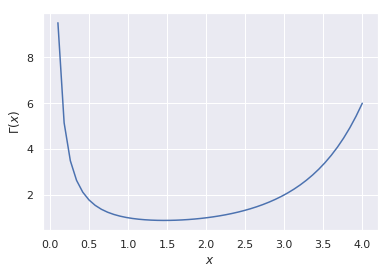

In [34]:
xx = np.linspace(0.1,4)
plt.plot(xx, sess.run(tf.exp(tf.lgamma(xx))))
plt.xlabel('$x$')
plt.ylabel(r'$\Gamma(x)$');

As you can see, it has a minimum around 1.5.  Write a algorithm to find the position of the minimum.


## Exercise: Minimizing functions of two variables


This scheme gets more complicated when we consider functions of multiple arguments.  The equivalent expansion in terms of gradients becomes

$$ \nabla f(\mathbf x) \approx \nabla f'(\mathbf {x_0}) + (\mathbf{x} - \mathbf{x_0})\cdot \nabla\ \nabla f(\mathbf{x_0}) $$

Setting all components of this equation to zero leads to $n$ equations for the $n$ components of $\mathbf x$.

If $\mathbf{x} = (x, y)$, we can do a bit of math to find the update rules

$$ x_{n+1} = x_n + \left. \left( \frac{\partial^2 f}{\partial x \partial y}\frac{\partial f}{\partial y} - \frac{\partial^2 f}{\partial y^2}\frac{\partial f}{\partial x} \right) \middle/ \left( \frac{\partial^2 f}{\partial x^2} \frac{\partial^2 f}{\partial y^2} - \left(\frac{\partial^2 f}{\partial x \partial y}\right)^2 \right)\right. $$

$$ y_{n+1} = y_n + \left. \left( \frac{\partial^2 f}{\partial x \partial y}\frac{\partial f}{\partial x} - \frac{\partial^2 f}{\partial x^2}\frac{\partial f}{\partial y} \right) \middle/ \left( \frac{\partial^2 f}{\partial x^2} \frac{\partial^2 f}{\partial y^2} - \left(\frac{\partial^2 f}{\partial x \partial y}\right)^2 \right)\right. $$

Use these to find the minimum of the function

$$ f(x, y) = x\,y - 0.5x \log(y) - y \log(x) - \log(2x + y) $$

(Consider only $x > 0$, $y > 0$.)  How sensitive is the algorithm to the initial condition?

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*